##Importing Dataset to colab folder

Upload the dataset in colab folder

In [1]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving Test.csv to Test.csv
Saving Train.csv to Train.csv
User uploaded file "Test.csv" with length 527709 bytes
User uploaded file "Train.csv" with length 869537 bytes


##**Reading Dataset**

###Importing Packages

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import sklearn

import warnings
warnings.filterwarnings('ignore')

###Reading data set



1.   Loading dataset using pandas
2.   View them

In [3]:
df_train = pd.read_csv('/content/Train.csv')

In [4]:
df_train.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052


In [5]:
print('The Dataset contains Rows is {} and columns is {}'.format(df_train.shape[0],df_train.shape[1]))

The Dataset contains Rows is 8523 and columns is 12


## **Handling Missing Values**

###Preprocessing


Find Missing values in columns

In [6]:
df_train.duplicated().sum()

0

In [7]:
feature_nan=[feature for feature in df_train.columns if df_train[feature].isnull().sum()>0]
feature_nan

['Item_Weight', 'Outlet_Size']

In [8]:
for feature in feature_nan:
    print('{} has {} % missing values'.format(feature,np.round(df_train[feature].isnull().sum()/len(df_train)*100,4)))

Item_Weight has 17.1653 % missing values
Outlet_Size has 28.2764 % missing values


Now, 2 columns having missing data.
* 1. `Item_Weight` is required. So we should handle.
* 2. `Outlet_Size ` is required


###Cleaning & Imputing Item_Weight column

In [9]:
print('The Missing Values in Item_Weight is {}'.format(df_train['Item_Weight'].isnull().sum()))

The Missing Values in Item_Weight is 1463


In [10]:
def impute_Item_Weight(df):
    item_avg_weight = df_train.groupby(["Item_Identifier"])["Item_Weight"].mean()
    item_avg_weight

    miss_bool = df_train['Item_Weight'].isnull() 

    print('Orignal missing of Item_Weight in this dataset: %d'% sum(miss_bool))
    df_train.loc[miss_bool,'Item_Weight'] = df_train.loc[miss_bool,'Item_Identifier'].apply(lambda x: item_avg_weight.loc[x])
    print('Final missing of Item_Weight in this dataset: %d'% sum(df_train['Item_Weight'].isnull()))

In [11]:
impute_Item_Weight(df_train)

Orignal missing of Item_Weight in this dataset: 1463
Final missing of Item_Weight in this dataset: 4


In [12]:
df_train[df_train['Item_Weight'].isnull()].head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
927,FDN52,NaN,Regular,0.130933,Frozen Foods,86.9198,OUT027,1985,Medium,Tier 3,Supermarket Type3,1569.9564
1922,FDK57,NaN,Low Fat,0.079904,Snack Foods,120.0440,OUT027,1985,Medium,Tier 3,Supermarket Type3,4434.2280
4187,FDE52,NaN,Regular,0.029742,Dairy,88.9514,OUT027,1985,Medium,Tier 3,Supermarket Type3,3453.5046
5022,FDQ60,NaN,Regular,0.191501,Baking Goods,121.2098,OUT019,1985,Small,Tier 1,Grocery Store,120.5098


In [13]:
df_train['Item_Weight'] = df_train['Item_Weight'].fillna(df_train['Item_Weight'].mean())

In [14]:
print('After imputing Missing Values in Item_Weight now it is contains {}'.format(df_train['Item_Weight'].isnull().sum()))

After imputing Missing Values in Item_Weight now it is contains 0


###Cleaning & Imputing Outlet_Size column

In [15]:
print('The Missing Values in Outlet_Size is {}'.format(df_train['Outlet_Size'].isnull().sum()))

The Missing Values in Outlet_Size is 2410


In [16]:
from scipy.stats import mode

def impute_Outlet_size(df):
    outlet_size_mode = df_train.pivot_table(values='Outlet_Size', columns='Outlet_Type',aggfunc=(lambda x:mode(x).mode[0]) )
    print('Mode for each Outlet_Type:')
    print(outlet_size_mode)

    miss_bool = df_train['Outlet_Size'].isnull() 

    print('\nOrignal #missing: %d'% sum(miss_bool))
    df_train.loc[miss_bool,'Outlet_Size'] = df_train.loc[miss_bool,'Outlet_Type'].apply(lambda x: outlet_size_mode[x])
    print('\nFinal #missing: %d'%sum(df['Outlet_Size'].isnull()))

In [17]:
impute_Outlet_size(df_train)

Mode for each Outlet_Type:
Outlet_Type Grocery Store Supermarket Type1 Supermarket Type2  \
Outlet_Size         Small             Small            Medium   

Outlet_Type Supermarket Type3  
Outlet_Size            Medium  

Orignal #missing: 2410

Final #missing: 0


## **Feature Engineering**

### Modify **`Item_Visibility`**

In [18]:
print('Number of 0 values initially: %d'%sum(df_train['Item_Visibility']==0))

Number of 0 values initially: 526


In [19]:
df_train['Item_Visibility'].mean()

0.06613202877895127

In [20]:
df_train.loc[:,'Item_Visibility'].replace([0],[df_train['Item_Visibility'].mean()],inplace=True)

In [21]:
print('Number of 0 values after modification: %d'%sum(df_train['Item_Visibility'] == 0))

Number of 0 values after modification: 0


### Modify categories of **`Item_Fat_Content`**

In [22]:
print('Original Categories:')
print(df_train['Item_Fat_Content'].value_counts())

Original Categories:
Low Fat    5089
Regular    2889
LF          316
reg         117
low fat     112
Name: Item_Fat_Content, dtype: int64


In [23]:
df_train['Item_Fat_Content'] = df_train['Item_Fat_Content'].replace({'LF':'Low Fat','reg':'Regular','low fat':'Low Fat'})

In [24]:
print('Modified Categories:')
print(df_train['Item_Fat_Content'].value_counts())

Modified Categories:
Low Fat    5517
Regular    3006
Name: Item_Fat_Content, dtype: int64


In [25]:
df_train.head(2)

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228


### Create a new column named as **`New_Item_Type`**

In [26]:
print(df_train['Item_Type'].unique())

['Dairy' 'Soft Drinks' 'Meat' 'Fruits and Vegetables' 'Household'
 'Baking Goods' 'Snack Foods' 'Frozen Foods' 'Breakfast'
 'Health and Hygiene' 'Hard Drinks' 'Canned' 'Breads' 'Starchy Foods'
 'Others' 'Seafood']


In [27]:
df_train.groupby(["Item_Identifier","Item_Type"]).size()

Item_Identifier  Item_Type         
DRA12            Soft Drinks           6
DRA24            Soft Drinks           7
DRA59            Soft Drinks           8
DRB01            Soft Drinks           3
DRB13            Soft Drinks           5
                                      ..
NCZ30            Household             7
NCZ41            Health and Hygiene    5
NCZ42            Household             5
NCZ53            Health and Hygiene    5
NCZ54            Household             7
Length: 1559, dtype: int64

In [28]:
df_train['New_Item_Type'] = df_train['Item_Identifier'].apply(lambda x:x[:2])

In [29]:
df_train['New_Item_Type']

0       FD
1       DR
2       FD
3       FD
4       NC
        ..
8518    FD
8519    FD
8520    NC
8521    FD
8522    DR
Name: New_Item_Type, Length: 8523, dtype: object

In [30]:
df_train['New_Item_Type'].unique()

array(['FD', 'DR', 'NC'], dtype=object)

In [31]:
df_train['New_Item_Type'].map({'FD':'Food','DR':'Drinks','NC':'Non-Consumable'})

0                 Food
1               Drinks
2                 Food
3                 Food
4       Non-Consumable
             ...      
8518              Food
8519              Food
8520    Non-Consumable
8521              Food
8522            Drinks
Name: New_Item_Type, Length: 8523, dtype: object

In [32]:
df_train['New_Item_Type'] = df_train['New_Item_Type'].map({'FD':'Food','DR':'Drinks','NC':'Non-Consumable'})

In [33]:
df_train['New_Item_Type'].value_counts()

Food              6125
Non-Consumable    1599
Drinks             799
Name: New_Item_Type, dtype: int64

In [34]:
df_train.loc[df_train['New_Item_Type']=='Non-Consumable','Item_Fat_Content']='Non-Edible'

In [35]:
df_train['Item_Fat_Content'].value_counts()

Low Fat       3918
Regular       3006
Non-Edible    1599
Name: Item_Fat_Content, dtype: int64

## **Visualization**

In [36]:
plt.figure(figsize=(8,6))
sns.set_style('whitegrid')

<Figure size 576x432 with 0 Axes>

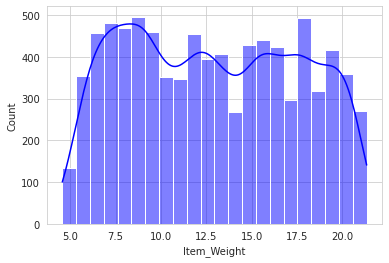

In [37]:
sns.histplot(data=df_train,x='Item_Weight',kde=True,color='blue')

we observe that
- Items falling in lower weight category might be Food
- Average weight items might include, soft- drinks 
- High weight categories might be heavy household items, etc.

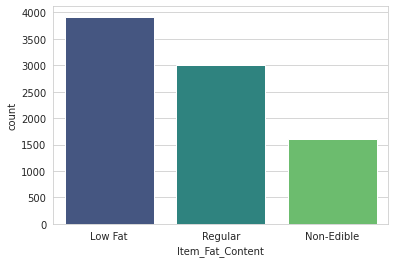

In [38]:
sns.countplot(x='Item_Fat_Content', data=df_train, palette="viridis");

we observe that
- Low fat can sold more than others

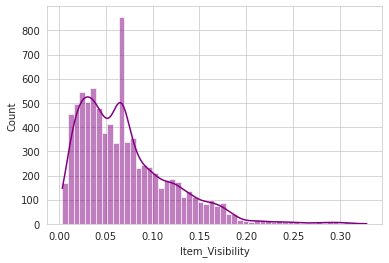

In [39]:
sns.histplot(data=df_train,x='Item_Visibility',kde=True,color='purple')

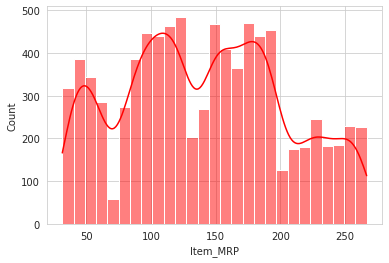

In [40]:
sns.histplot(data=df_train,x='Item_MRP',kde=True,color='red')

We can clearly observe that
- A fair number of items are found in lower price categories.
- Most of the items have Price lying in Medium or High category.
- Small number of items are there which come in Very High Price range.

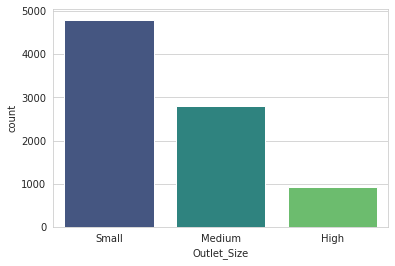

In [41]:
sns.countplot(x='Outlet_Size', data=df_train, palette="viridis", order=['Small', 'Medium', 'High']);

We observe that
- Most of the stores are of Small Size type.
- A small number of them are Medium Sized.
- And very less number of stores are Large Sized.

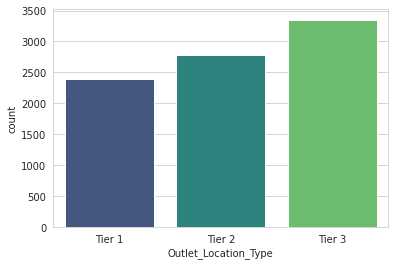

In [42]:
sns.countplot(x='Outlet_Location_Type', data=df_train, palette="viridis", order=['Tier 1', 'Tier 2', 'Tier 3']);

We observed that
- We see the distribution of Outlets in different city types, and found out that there are more number of Outlets in Tier 3 cities, probably because the cost of land, electricity, and setting up Outlet is lower there.
- Then Tier 2 cities have lesser number of Outlets than Tier 3, but more than Tier 1 cities.
- Tier 1 cities have lesser number of Outlets, might be because of the cost factor, or more practically, because of the busy lifestyle of people there, people prefer Online Shopping more.

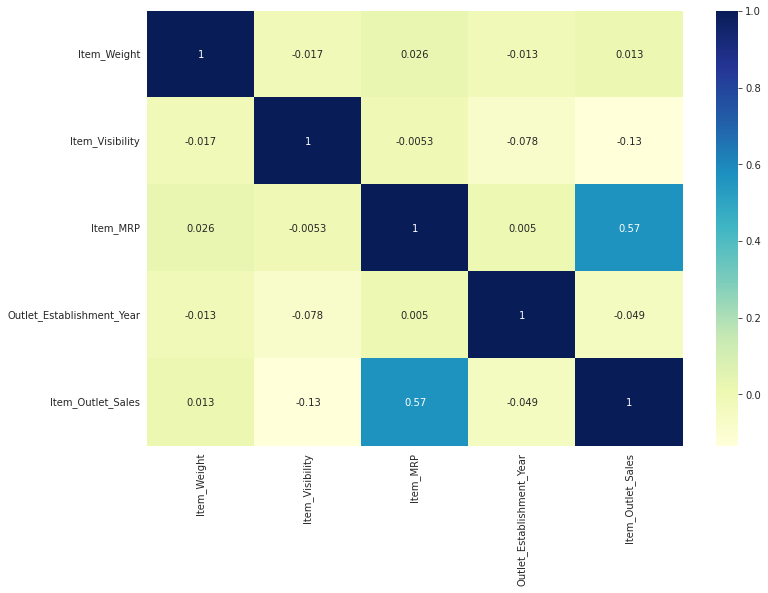

In [43]:
plt.figure(figsize=(12,8));
sns.heatmap(df_train.corr(), cmap="YlGnBu",annot=True);

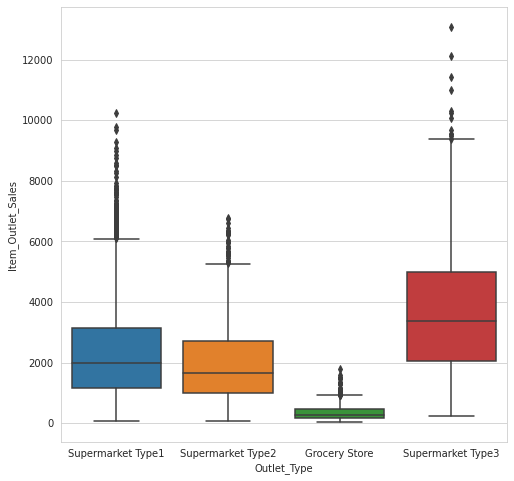

In [44]:
plt.figure(figsize=(8,8))
sns.boxplot('Outlet_Type', 'Item_Outlet_Sales', data=df_train);

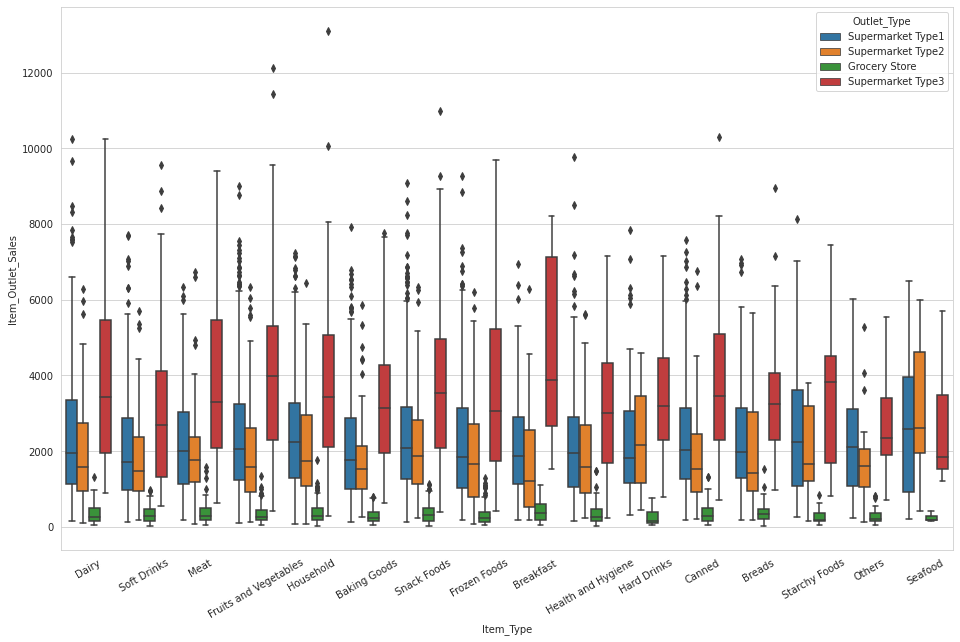

In [45]:
plt.figure(figsize=(16,10))
ax = sns.boxplot('Item_Type', 'Item_Outlet_Sales', data=df_train, hue='Outlet_Type');
ax.set_xticklabels(ax.get_xticklabels(),rotation=30);

We observed that
- Grocery stores have much lesser sales than Supermarkets, which is confirmed from above two plots.
- On whole, if we look at distinction between Supermarket types, Supermarket type 3 has higher sales than other two.
- Supermarket type 1 and type 2, however, cannot be differentiated much.

## Test data

In [46]:
df_test = pd.read_csv('/content/Test.csv')

In [47]:
df_test.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type
0,FDW58,20.750,Low Fat,0.007565,Snack Foods,107.8622,OUT049,1999,Medium,Tier 1,Supermarket Type1
1,FDW14,8.300,reg,0.038428,Dairy,87.3198,OUT017,2007,NaN,Tier 2,Supermarket Type1
2,NCN55,14.600,Low Fat,0.099575,Others,241.7538,OUT010,1998,NaN,Tier 3,Grocery Store
3,FDQ58,7.315,Low Fat,0.015388,Snack Foods,155.0340,OUT017,2007,NaN,Tier 2,Supermarket Type1
4,FDY38,NaN,Regular,0.118599,Dairy,234.2300,OUT027,1985,Medium,Tier 3,Supermarket Type3


In [48]:
print('The Dataset contains Rows is {} and columns is {}'.format(df_test.shape[0],df_test.shape[1]))

The Dataset contains Rows is 5681 and columns is 11


In [49]:
print('The Missing Values in Item_Weight is {}'.format(df_test['Item_Weight'].isnull().sum()))

def impute_Item_Weight(df):
    item_avg_weight = df_test.groupby(["Item_Identifier"])["Item_Weight"].mean()
    item_avg_weight

    miss_bool = df_test['Item_Weight'].isnull() 

    print('Orignal missing of Item_Weight in this dataset: %d'% sum(miss_bool))
    df_test.loc[miss_bool,'Item_Weight'] = df_test.loc[miss_bool,'Item_Identifier'].apply(lambda x: item_avg_weight.loc[x])
    print('Final missing of Item_Weight in this dataset: %d'% sum(df_test['Item_Weight'].isnull()))

impute_Item_Weight(df_test)

The Missing Values in Item_Weight is 976
Orignal missing of Item_Weight in this dataset: 976
Final missing of Item_Weight in this dataset: 20


In [50]:
df_test[df_test['Item_Weight'].isnull()].head()

df_test['Item_Weight'] = df_test['Item_Weight'].fillna(df_test['Item_Weight'].mean())

print('After imputing Missing Values in Item_Weight now it is contains {}'.format(df_test['Item_Weight'].isnull().sum()))

After imputing Missing Values in Item_Weight now it is contains 0


In [51]:
print('The Missing Values in Outlet_Size is {}'.format(df_test['Outlet_Size'].isnull().sum()))

from scipy.stats import mode

def impute_Outlet_size(df):
    outlet_size_mode = df_test.pivot_table(values='Outlet_Size', columns='Outlet_Type',aggfunc=(lambda x:mode(x).mode[0]) )
    print('Mode for each Outlet_Type:')
    print(outlet_size_mode)

    miss_bool = df_test['Outlet_Size'].isnull() 

    print('\nOrignal #missing: %d'% sum(miss_bool))
    df_test.loc[miss_bool,'Outlet_Size'] = df_test.loc[miss_bool,'Outlet_Type'].apply(lambda x: outlet_size_mode[x])
    print('\nFinal #missing: %d'%sum(df_test['Outlet_Size'].isnull()))

impute_Outlet_size(df_test)

The Missing Values in Outlet_Size is 1606
Mode for each Outlet_Type:
Outlet_Type Grocery Store Supermarket Type1 Supermarket Type2  \
Outlet_Size         Small             Small            Medium   

Outlet_Type Supermarket Type3  
Outlet_Size            Medium  

Orignal #missing: 1606

Final #missing: 0


In [52]:
print('Number of 0 values initially: %d'%sum(df_test['Item_Visibility']==0))

df_test['Item_Visibility'].mean()

df_test.loc[:,'Item_Visibility'].replace([0],[df_test['Item_Visibility'].mean()],inplace=True)

print('Number of 0 values after modification: %d'%sum(df_test['Item_Visibility'] == 0))

Number of 0 values initially: 353
Number of 0 values after modification: 0


In [53]:
print('Original Categories:')
print(df_test['Item_Fat_Content'].value_counts())

df_test['Item_Fat_Content'] = df_test['Item_Fat_Content'].replace({'LF':'Low Fat','reg':'Regular','low fat':'Low Fat'})

print()
print()

print('Modified Categories:')
print(df_test['Item_Fat_Content'].value_counts())

Original Categories:
Low Fat    3396
Regular    1935
LF          206
reg          78
low fat      66
Name: Item_Fat_Content, dtype: int64


Modified Categories:
Low Fat    3668
Regular    2013
Name: Item_Fat_Content, dtype: int64


In [54]:
df_test['New_Item_Type'] = df_test['Item_Identifier'].apply(lambda x:x[:2])

df_test['New_Item_Type'].unique()

df_test['New_Item_Type'] = df_test['New_Item_Type'].map({'FD':'Food','DR':'Drinks','NC':'Non-Consumable'})
df_test['New_Item_Type'].value_counts()


Food              4076
Non-Consumable    1087
Drinks             518
Name: New_Item_Type, dtype: int64

In [55]:
df_test.loc[df_test['New_Item_Type']=='Non-Consumable','Item_Fat_Content']='Non-Edible'

df_test['Item_Fat_Content'].value_counts()

Low Fat       2581
Regular       2013
Non-Edible    1087
Name: Item_Fat_Content, dtype: int64

### Save the Dataset

In [70]:
df_train.to_csv("modified_train.csv",index = False)

In [69]:
df_test.to_csv("modified_test.csv",index = False)